In [11]:
### Stand alone script to analyze json results 
import sys
sys.path.append("..")
from models.config import DATA, WRITE_CONFIG, PLOT_CONFIG, ANALYZE_CONFIG, HYPERPARAMETERS, XML_NAME
import matplotlib.pyplot as plt
from writer import ResultStore
import os
import xml.etree.ElementTree as ET
from collections import Counter
import numpy as np
import json

In [68]:

# Extract Data
results_path = os.path.join(WRITE_CONFIG['tuning_path'], 'results.json')

with open(results_path) as file:
    results = json.load(file)

# Log Top 5
top_5_dict = {}
for image_name, structures in results.items():
    for struct, data in structures.items():
        sorted_data = sorted(data, key=lambda x: x['dice_score'], reverse=True)[:5]
        if struct not in top_5_dict:
            top_5_dict[struct] = []
        top_5_dict[struct].extend(sorted_data)

print(len(top_5_dict['iris']))


# This function will determine the most common hyperparameters for each structure
most_common_params = {}

for struct, data in top_10_dict.items():
    # Create a list of tuples for each hyperparameter combination in the data
    hp_combinations = [(entry['jitter_percent'], entry['mask_percent'], entry['preprocessing']) for entry in data]
    
    # Use Counter to count occurrences of each combination
    counter = Counter(hp_combinations)
    
    # Find the most common combination
    most_common_combo, count = counter.most_common(1)[0]
    
    most_common_params[struct] = {
        'jitter_percent': most_common_combo[0],
        'mask_percent': most_common_combo[1],
        'preprocessing': most_common_combo[2],
        'count': count
    }
    
for key, value in most_common_params.items():
    print(key, value)

225
iris {'jitter_percent': 0.1, 'mask_percent': 0.1, 'preprocessing': 'gamma_correction', 'count': 14}
brows {'jitter_percent': 0.1, 'mask_percent': 0.1, 'preprocessing': 'contrast', 'count': 32}
sclera {'jitter_percent': 0.2, 'mask_percent': 0.5, 'preprocessing': 'adaptive_histogram', 'count': 13}
pupil {'jitter_percent': 0.2, 'mask_percent': 0.5, 'preprocessing': 'none', 'count': 32}


In [57]:
def calculate_stats_for_hyperparameters(results, struct):
    # This dictionary will hold a list of Dice scores for each hyperparameter combination
    hp_scores = {}

    # Step 2 & 3: Iterate through each image's data and gather scores for each hyperparameter combo
    for image_name, structures in results.items():
        iris_data = structures.get(struct, [])
        for entry in iris_data:
            hp_combo = (entry['jitter_percent'], entry['mask_percent'], entry['preprocessing'])
            if hp_combo not in hp_scores:
                hp_scores[hp_combo] = []
            hp_scores[hp_combo].append(entry['dice_score'])

    # Step 5: Calculate average and standard deviation
    stats = {}
    for combo, scores in hp_scores.items():
        avg = sum(scores) / len(scores)
        variance = sum([(s - avg)**2 for s in scores]) / len(scores)
        stddev = variance**0.5
        stats[combo] = {'avg': avg, 'stddev': stddev}
        
    return stats

iris_stats = calculate_stats_for_hyperparameters(results, 'iris')
brow_stats = calculate_stats_for_hyperparameters(results, 'brows')
sclera_stats = calculate_stats_for_hyperparameters(results, 'sclera')
pupil_stats = calculate_stats_for_hyperparameters(results, 'pupil')

def top_hyperparameters(stats, top_n=3):
    # Sort by average dice score in descending order
    sorted_stats = sorted(stats.items(), key=lambda x: x[1]['avg'], reverse=True)
    
    # Fetch top N entries
    top_entries = sorted_stats[:top_n]
    
    return top_entries

# Fetch the top 3 hyperparameters for each structure
top_iris = top_hyperparameters(iris_stats)
top_brows = top_hyperparameters(brow_stats)
top_pupil = top_hyperparameters(pupil_stats)
top_sclera = top_hyperparameters(sclera_stats)


# Print results
print("Top 3 Hyperparameters for Iris:")
for combo, values in top_iris:
    print(f"Combo: {combo}, Average Dice Score: {values['avg']:.4f}, Standard Deviation: {values['stddev']:.4f}")

print("\nTop 3 Hyperparameters for Brows:")
for combo, values in top_brows:
    print(f"Combo: {combo}, Average Dice Score: {values['avg']:.4f}, Standard Deviation: {values['stddev']:.4f}")

print("\nTop 3 Hyperparameters for Pupil:")
for combo, values in top_pupil:
    print(f"Combo: {combo}, Average Dice Score: {values['avg']:.4f}, Standard Deviation: {values['stddev']:.4f}")

print("\nTop 3 Hyperparameters for Sclera:")
for combo, values in top_sclera:
    print(f"Combo: {combo}, Average Dice Score: {values['avg']:.4f}, Standard Deviation: {values['stddev']:.4f}")

Top 3 Hyperparameters for Iris:
Combo: (0.2, 0.5, 'gamma_correction'), Average Dice Score: 0.9586, Standard Deviation: 0.0197
Combo: (0.2, 0.4, 'gamma_correction'), Average Dice Score: 0.9581, Standard Deviation: 0.0246
Combo: (0.15, 0.4, 'gamma_correction'), Average Dice Score: 0.9577, Standard Deviation: 0.0239

Top 3 Hyperparameters for Brows:
Combo: (0.05, 0.1, 'contrast'), Average Dice Score: 0.8061, Standard Deviation: 0.0748
Combo: (0.1, 0.1, 'contrast'), Average Dice Score: 0.8051, Standard Deviation: 0.0850
Combo: (0.05, 0.2, 'contrast'), Average Dice Score: 0.8045, Standard Deviation: 0.0737

Top 3 Hyperparameters for Pupil:
Combo: (0.2, 0.5, 'none'), Average Dice Score: 0.6472, Standard Deviation: 0.1965
Combo: (0.05, 0.5, 'none'), Average Dice Score: 0.6423, Standard Deviation: 0.2097
Combo: (0.15, 0.5, 'none'), Average Dice Score: 0.6419, Standard Deviation: 0.2000

Top 3 Hyperparameters for Sclera:
Combo: (0.2, 0.5, 'none'), Average Dice Score: 0.9298, Standard Deviation:

[0.9540400737261431]
[0.8377718497083692]
[]
[]


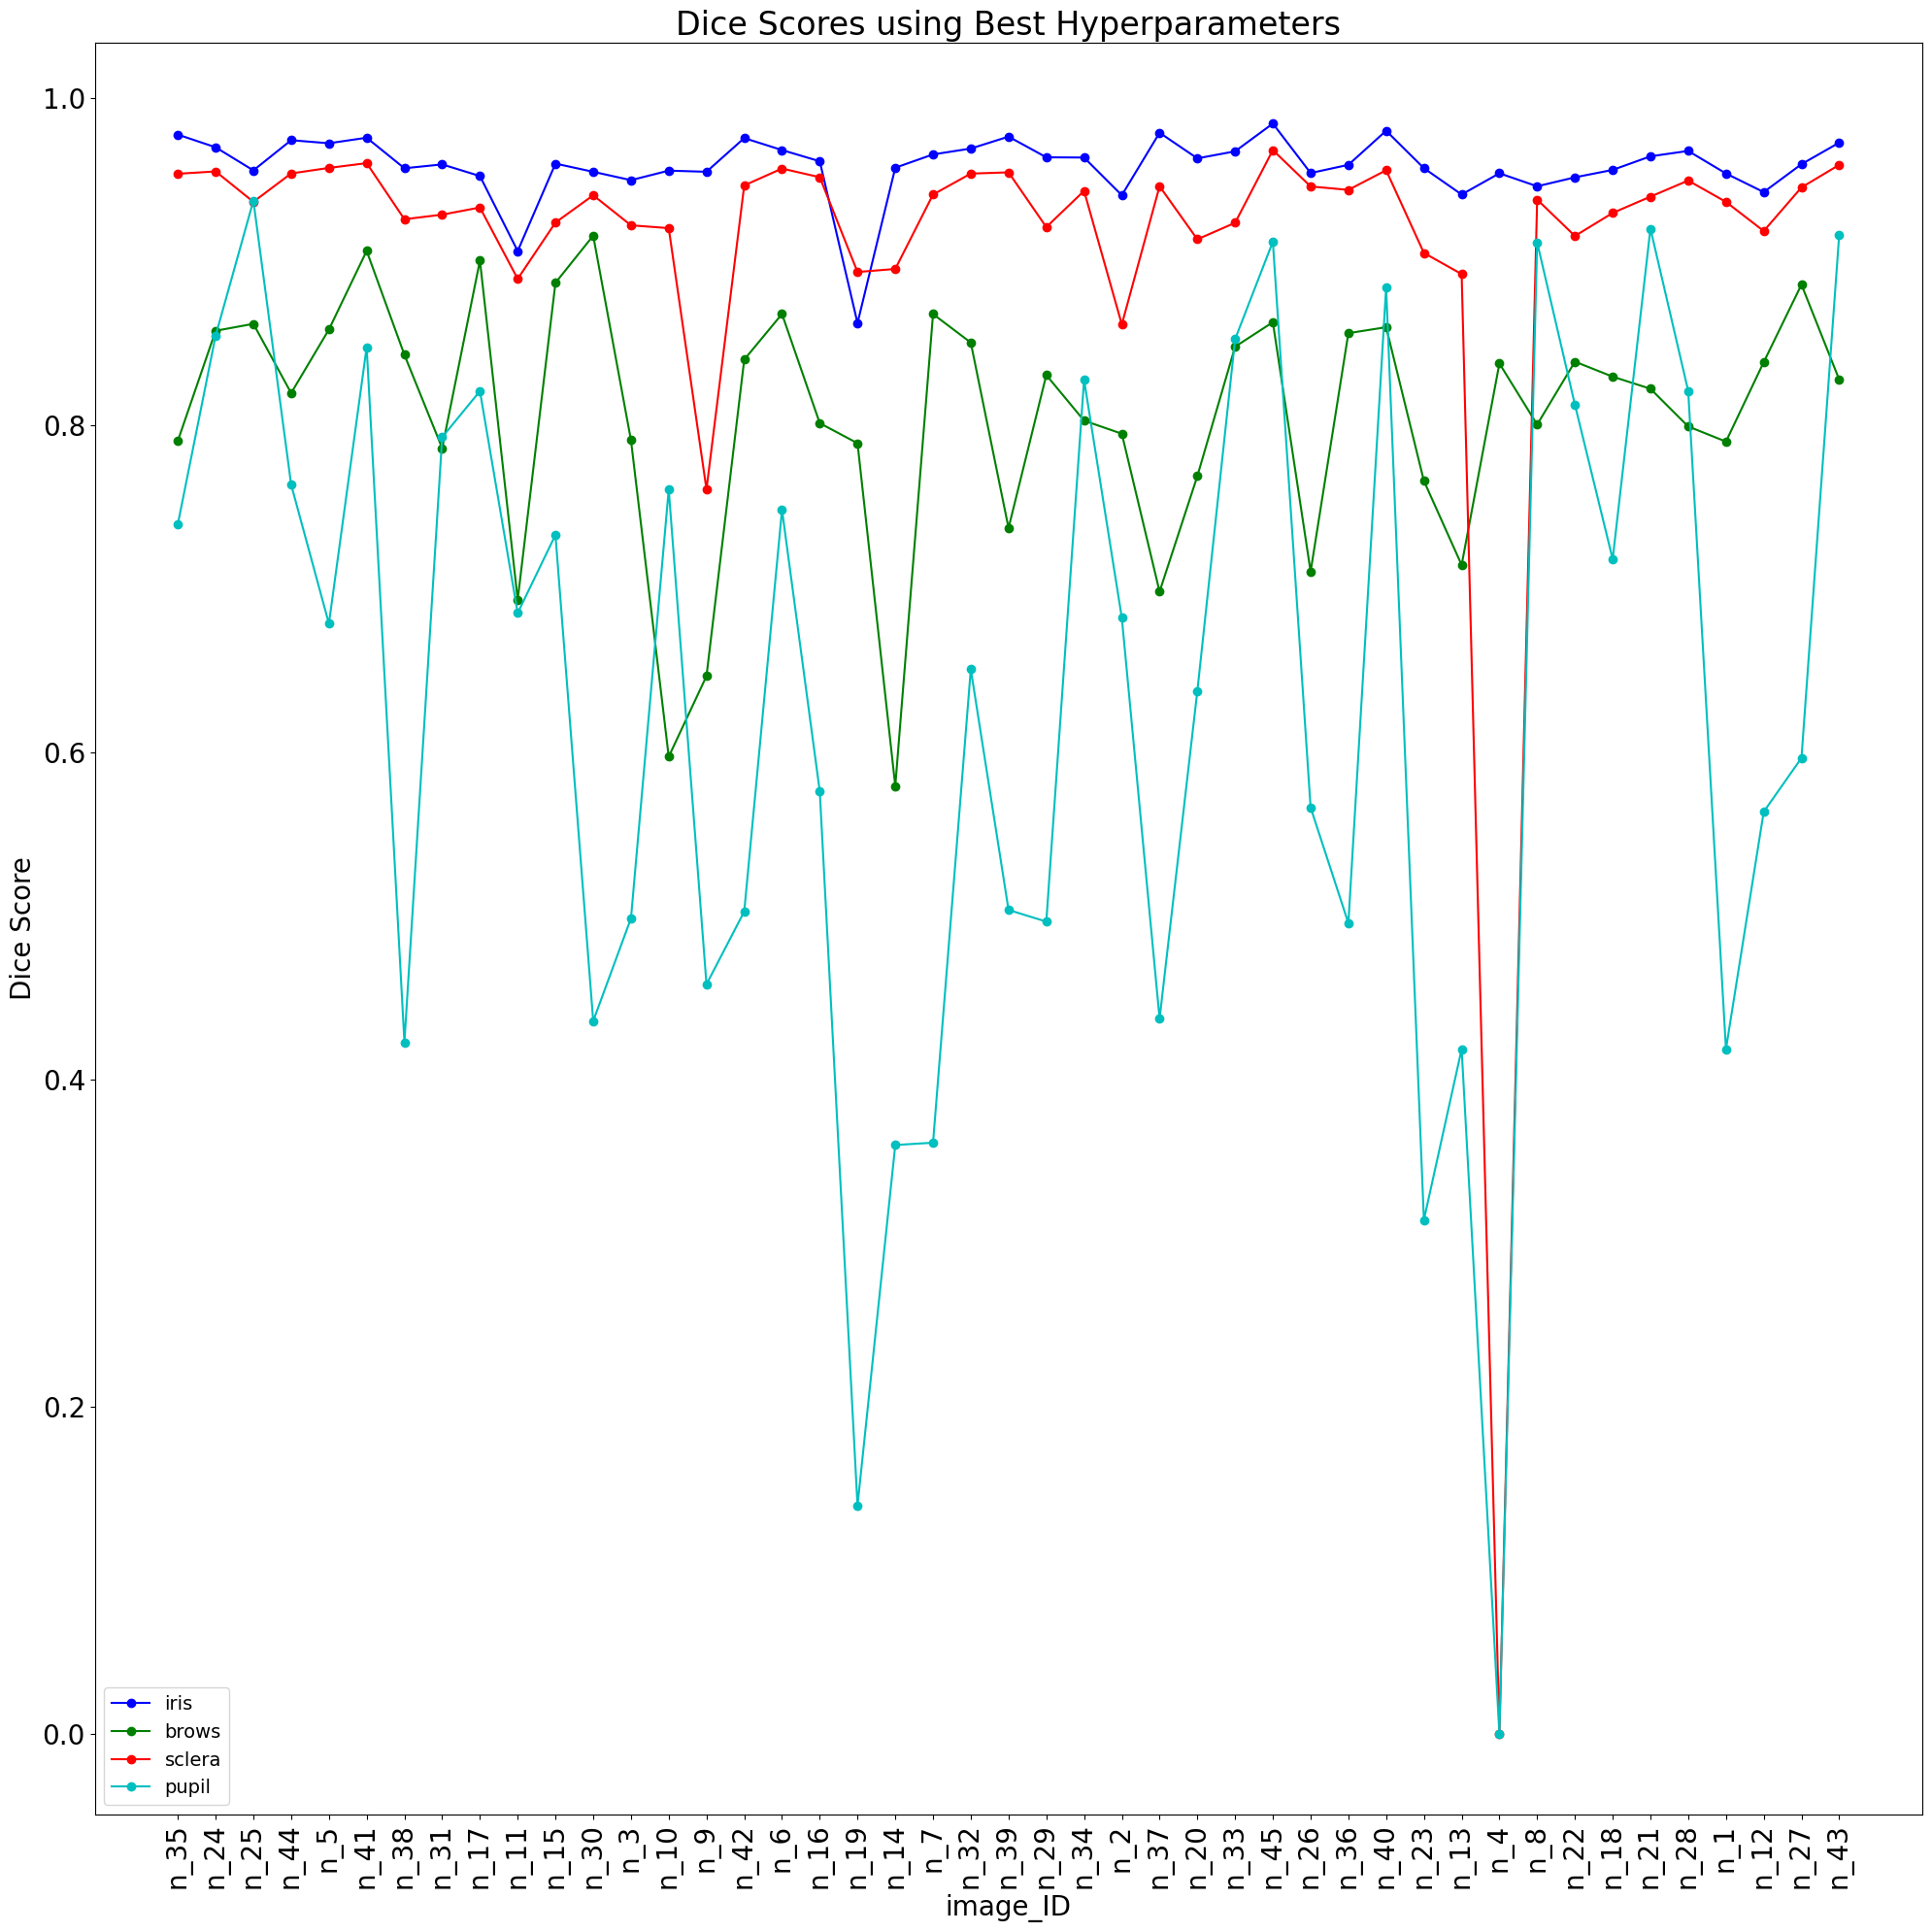

In [81]:
# Define best hyperparameters for each structure
best_hyperparams = {
    'iris': (0.2, 0.5, 'gamma_correction'),
    'brows': (0.05, 0.1, 'contrast'),
    'pupil': (0.2, 0.5, 'none'),
    'sclera': (0.2, 0.5, 'none')
}

plt.figure(figsize=(20, 20))
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20

plt.title('Dice Scores using Best Hyperparameters')
plt.xlabel('image_ID')
plt.ylabel('Dice Score')

colors = ['b', 'g', 'r', 'c']

for idx, struct in enumerate(['iris', 'brows', 'sclera', 'pupil']):
    dice_scores = []
    
    # Hyperparameters for this structure
    hp = best_hyperparams[struct]
    
    # Iterate over each image's results
    for image_name, structures in results.items():
        # Extract the dice score that matches the best hyperparameters
        scores_for_struct = [entry['dice_score'] for entry in structures.get(struct, []) if 
                             (entry['jitter_percent'], entry['mask_percent'], entry['preprocessing']) == hp]
        if image_name == 'n_4':
            print(scores_for_struct)
        # Append the score if found, otherwise append 0
        dice_scores.append(scores_for_struct[0] if scores_for_struct else 0)
    
    # Plot scores for the current structure
    plt.plot(results.keys(), dice_scores, color=colors[idx], marker='o', label=struct)

plt.legend(fontsize=14)  # Show the legend with increased font size
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
plt.tight_layout()  # Ensure the layout is good
plt.show()


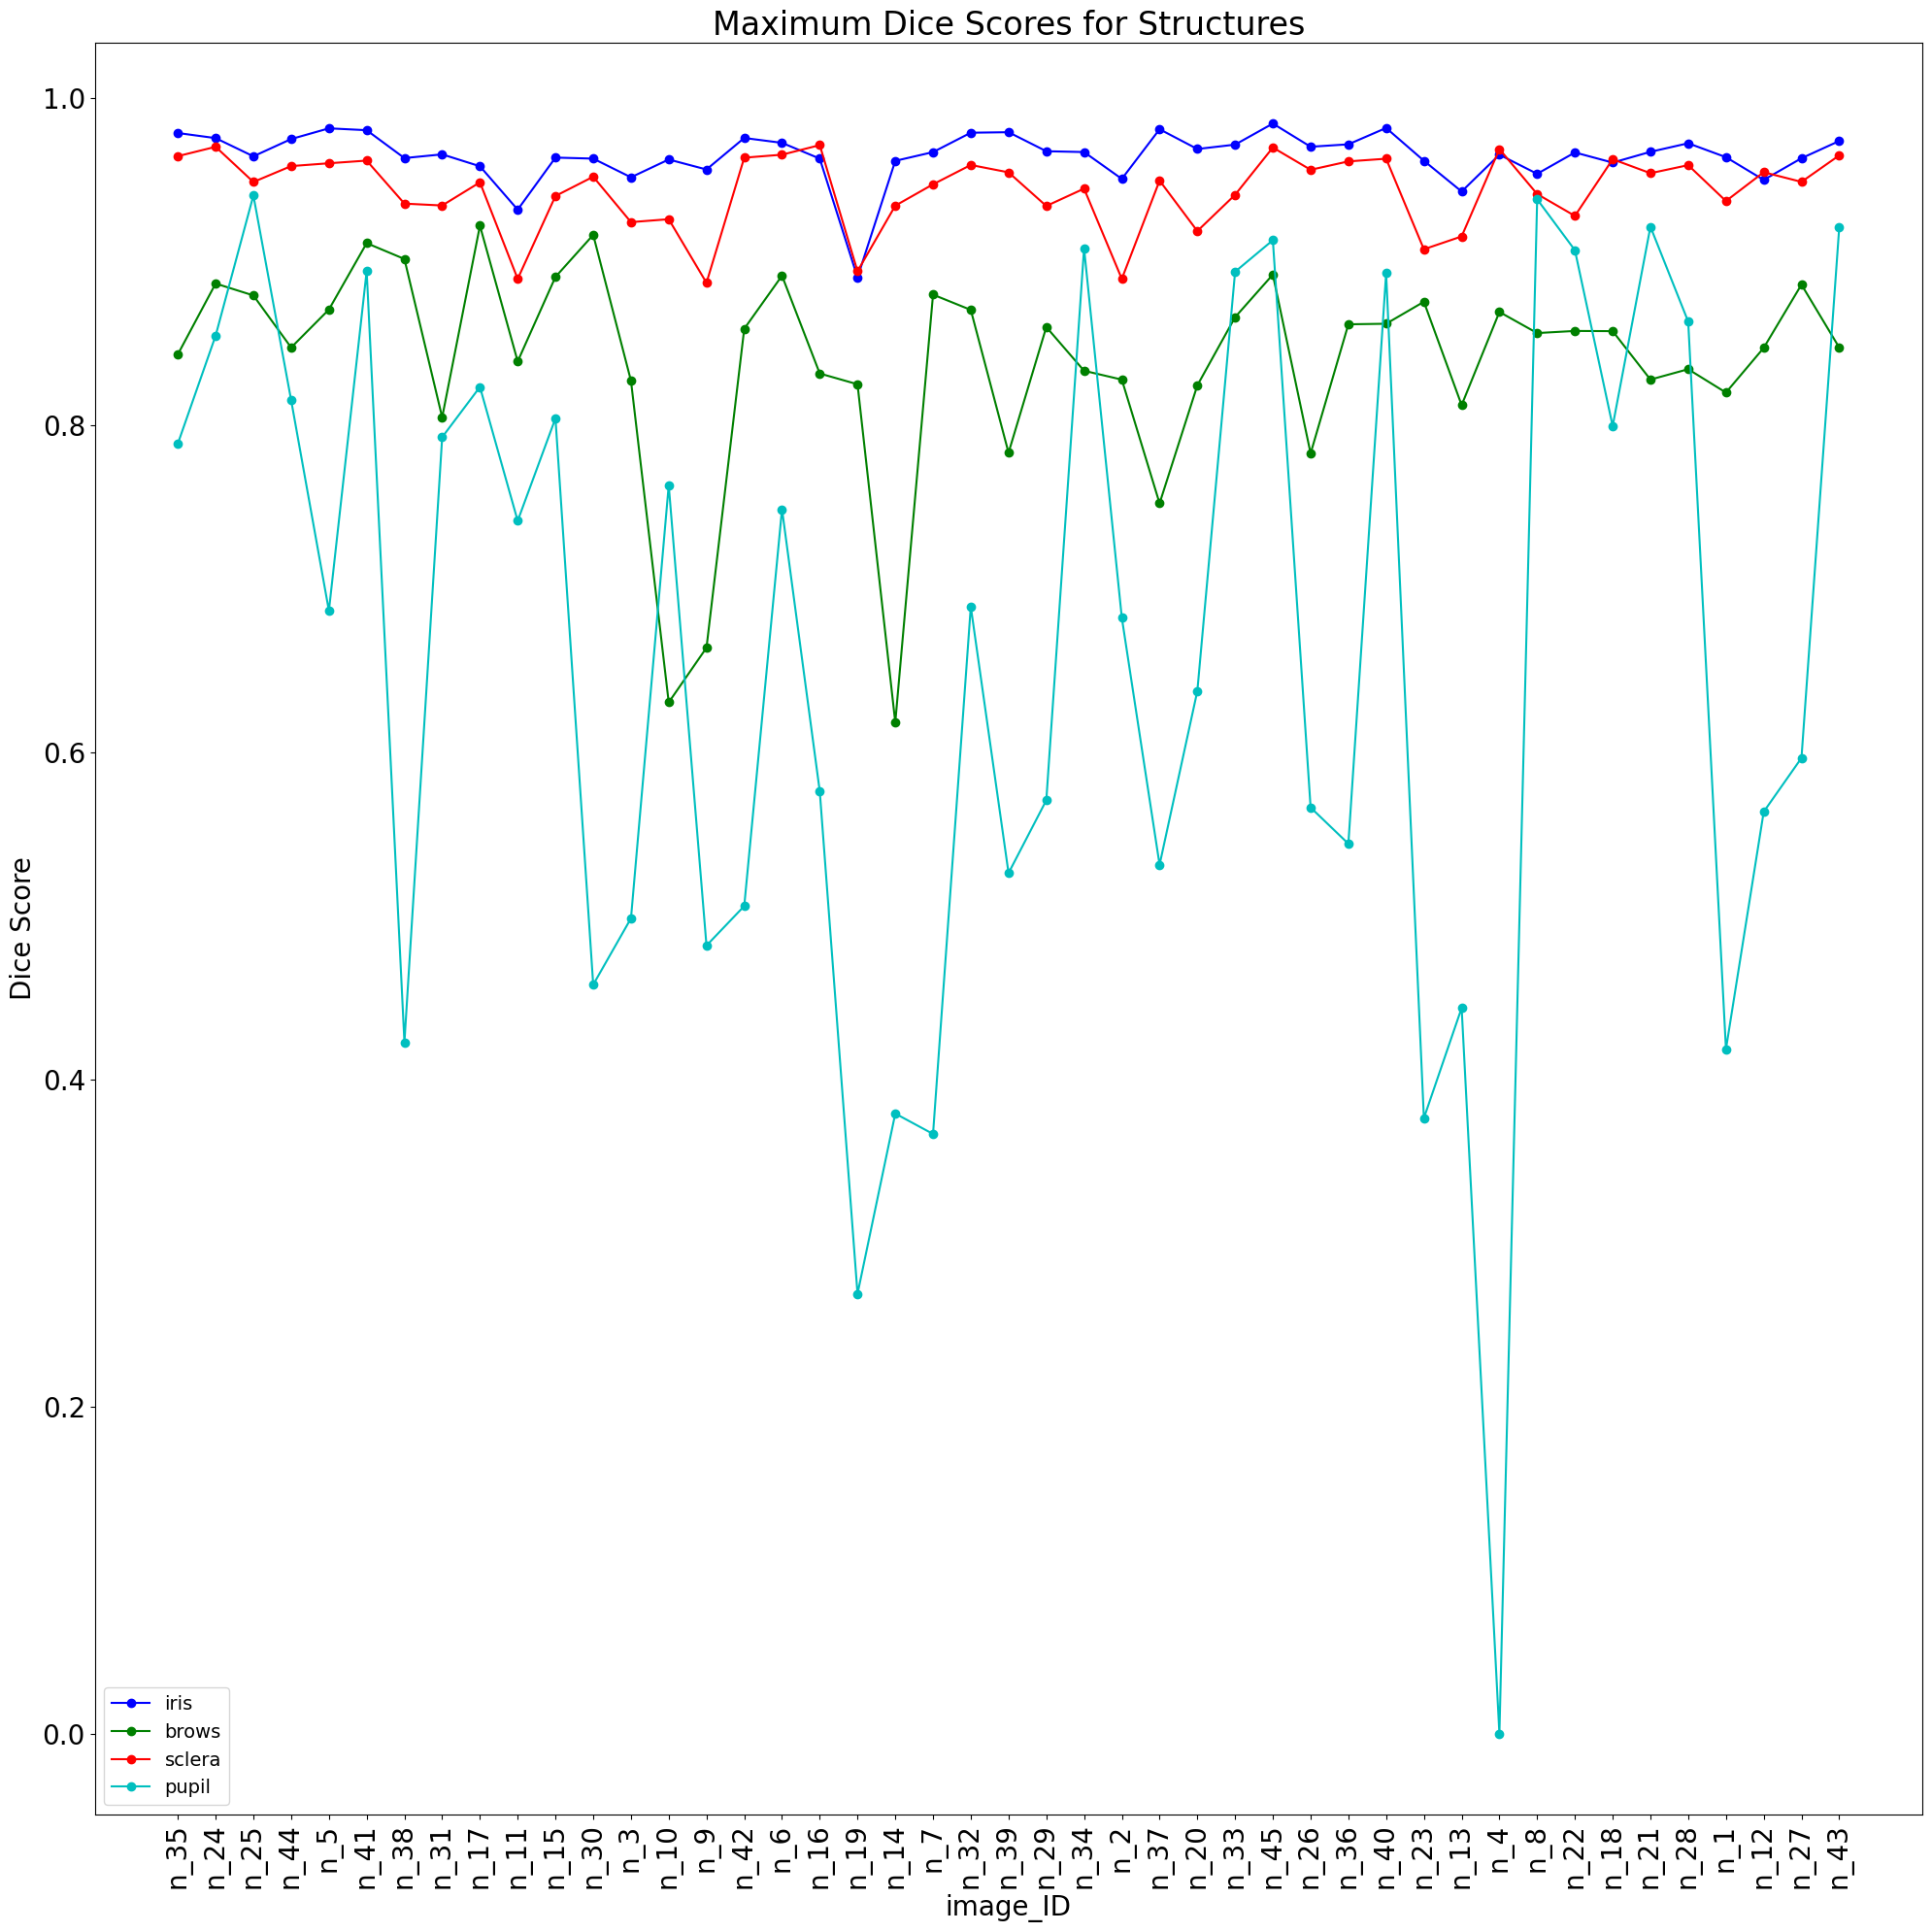

In [78]:
plt.figure(figsize=(20, 20))
plt.title('Maximum Dice Scores for Structures')
plt.xlabel('image_ID')
plt.ylabel('Dice Score')

plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20

# List of colors for different structures (to distinguish them)
colors = ['b', 'g', 'r', 'c']

for idx, struct in enumerate(['iris', 'brows', 'sclera', 'pupil']):
    dice_scores = []
    
    # Iterate over each image's results
    for image_name, structures in results.items():
        
        # Check if the structure is present in the results for the current image
        if struct in structures:
            scores_for_struct = [entry['dice_score'] for entry in structures[struct]]
            max_score = max(scores_for_struct)
        else:
            max_score = 0
    
        dice_scores.append(max_score)
    
    # Plot scores for the current structure
    plt.plot(results.keys(), dice_scores, color=colors[idx], marker='o', label=struct)

plt.legend(fontsize=14)  
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility if they overlap
plt.tight_layout()  # Ensure the layout is good, especially if x-axis labels are long
plt.show()


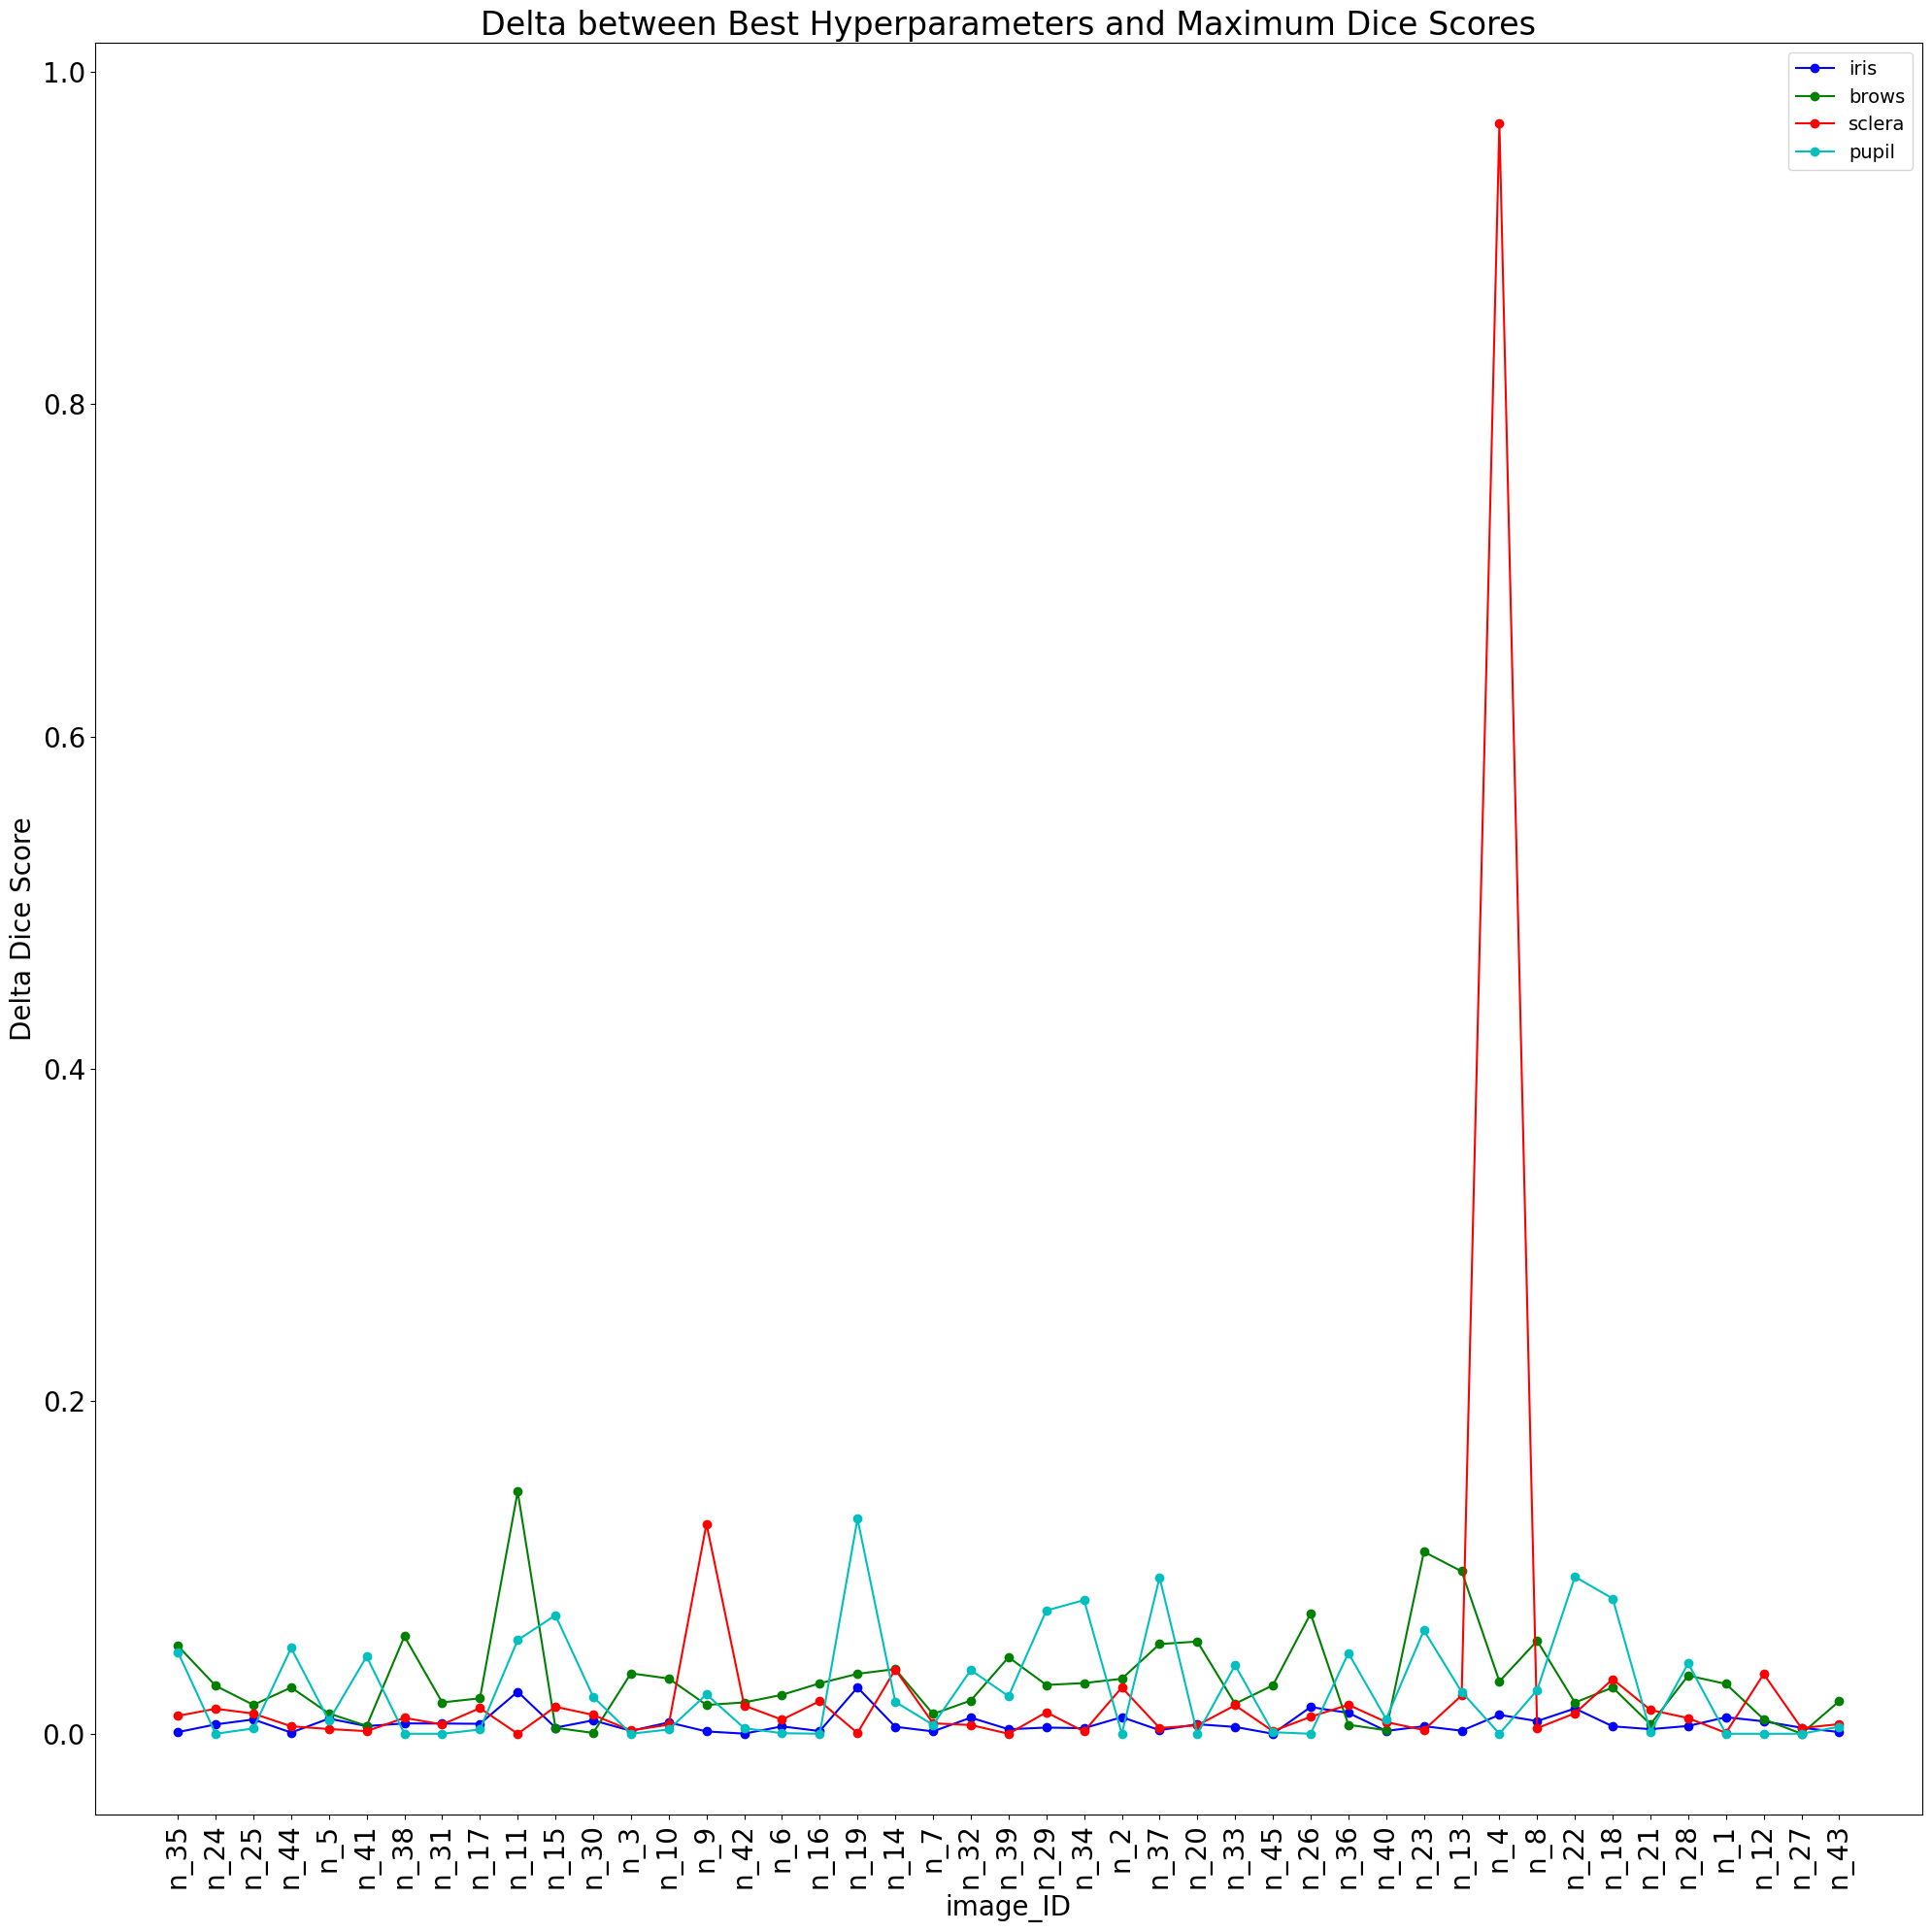

In [82]:
plt.figure(figsize=(20, 20))
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20

plt.title('Delta between Best Hyperparameters and Maximum Dice Scores')
plt.xlabel('image_ID')
plt.ylabel('Delta Dice Score')

colors = ['b', 'g', 'r', 'c']

for idx, struct in enumerate(['iris', 'brows', 'sclera', 'pupil']):
    
    best_hp_scores = []
    max_scores = []
    
    # Hyperparameters for this structure
    hp = best_hyperparams[struct]
    
    # Compute the dice scores for each image using the best hyperparameters
    for image_name, structures in results.items():
        scores_for_struct = [entry['dice_score'] for entry in structures.get(struct, []) if 
                             (entry['jitter_percent'], entry['mask_percent'], entry['preprocessing']) == hp]
        best_hp_scores.append(scores_for_struct[0] if scores_for_struct else 0)
        
        if struct in structures:
            scores_for_struct = [entry['dice_score'] for entry in structures[struct]]
            max_score = max(scores_for_struct)
        else:
            max_score = 0
        max_scores.append(max_score)
    
    # Calculate the delta values
    deltas = [max_score - best_hp_score for max_score, best_hp_score in zip(max_scores, best_hp_scores)]
    
    # Plot delta values for the current structure
    plt.plot(results.keys(), deltas, color=colors[idx], marker='o', label=struct)

plt.legend(fontsize=14)  
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
plt.tight_layout()  # Ensure the layout is good
plt.show()
